# Bitcoin price forecast


In [60]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [61]:
# dataset @ https://finance.yahoo.com/quote/BTC-USD/history/
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727
1,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380
2,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560
3,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059
4,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556


In [62]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2019-01-18,3657.839355
1,2019-01-19,3728.568359
2,2019-01-20,3601.013672
3,2019-01-21,3576.032471
4,2019-01-22,3604.577148


In [63]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [64]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

0   2019-01-18
1   2019-01-19
2   2019-01-20
3   2019-01-21
4   2019-01-22
Name: Date, dtype: datetime64[ns]

In [65]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2019-01-18,3657.839355
2019-01-19,3728.568359
2019-01-20,3601.013672
2019-01-21,3576.032471
2019-01-22,3604.577148


In [66]:
period_in_days = 10
df['Change'] = (df['Close'].shift(-period_in_days) - df['Close']) / df['Close']
df.drop(df.index[-period_in_days:], inplace=True)
df.head()

,Close,Change
Date,,
2019-01-28,3470.450439,-0.051229
2019-01-29,3448.116943,-0.075217
2019-01-30,3486.181641,-0.031889
2019-01-31,3457.792725,-0.033065
2019-02-01,3487.945313,-0.032357


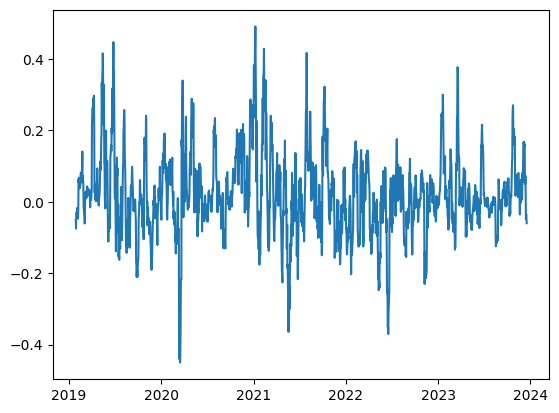

In [67]:
plt.plot(df.index, df['Change'])

In [68]:
change_percentages = list(range(3, 7))
column_changes_names = []
for percentage in change_percentages:
  column_change_name = f'Change_bin_{percentage}'
  df[column_change_name] = (df['Change'] >= percentage/100).astype(int)
  column_changes_names.append(column_change_name)
df.pop('Change')
df.head()

,Close,Change,Change_bin_3,Change_bin_4,Change_bin_5,Change_bin_6
Date,,,,,,
2019-01-28,3470.450439,-0.051229,0,0,0,0
2019-01-29,3448.116943,-0.075217,0,0,0,0
2019-01-30,3486.181641,-0.031889,0,0,0,0
2019-01-31,3457.792725,-0.033065,0,0,0,0
2019-02-01,3487.945313,-0.032357,0,0,0,0


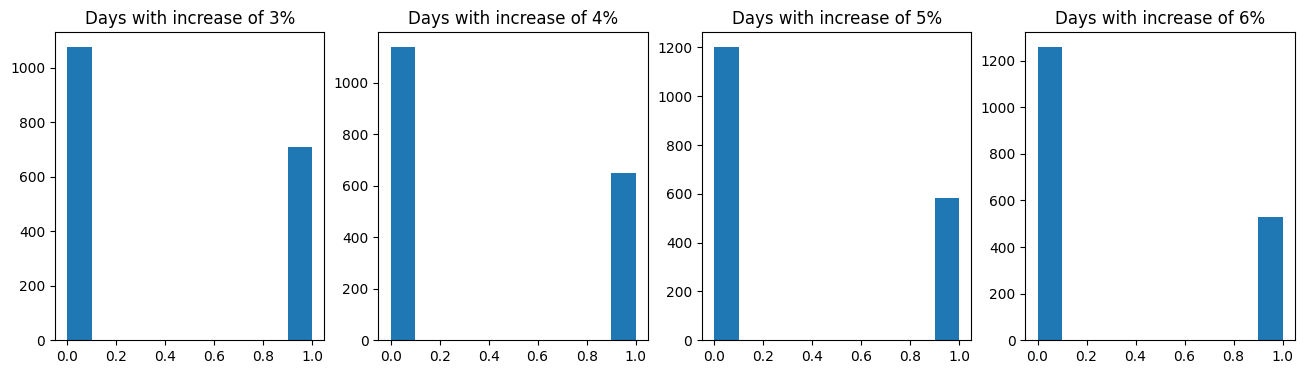

In [69]:
fig, axes = plt.subplots(1, len(change_percentages), figsize=(16, 4))
for i in range(len(change_percentages)):
  ax = axes[i]
  percentage = change_percentages[i]
  ax.hist(df[f'Change_bin_{percentage}'], range=(0, 1))
  ax.set_title(f'Days with increase of {percentage}%')
plt.show()

In [70]:
import numpy as np

def df_to_windowed_df(dataframe, n=3):
  target = dataframe.loc[:,dataframe.columns[-1]].to_numpy()
  dates = dataframe.index[n:].to_numpy()
  Y = target[n:]
  feat_amount = len(dataframe.columns) - 1
  input_columns = []
  for i in range(1, feat_amount + 1):
    input_columns.append(dataframe.loc[:,dataframe.columns[-1 * i - 1]].to_numpy())

  X = []
  for i in range(feat_amount):
    X.append([])
  for i in range(1, n + 1):
    for j in range(feat_amount):
      X[j].append(input_columns[j][n-i:-i])

  for i in range(feat_amount):
    X[i].reverse()

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for i in range(0, n):
    for j in range(feat_amount):
      ret_df[f'Target-{j}-{n-i}'] = X[j][i]

  ret_df['Target'] = Y

  return ret_df

In [71]:
df_set = {}
for col_change_name in column_changes_names:
  df_tmp = df.copy()
  df_tmp = df_tmp[['Close', col_change_name]]
  df_set[col_change_name] = df_tmp
for key in df_set.keys():
  print(df_set[key].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2019-01-28 to 2023-12-18
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1786 non-null   float64
 1   Change_bin_3  1786 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 41.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2019-01-28 to 2023-12-18
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1786 non-null   float64
 1   Change_bin_4  1786 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 41.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2019-01-28 to 2023-12-18
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1786 non-null   float64
 1   Change_bin_5  1786 non-null   int64  


In [72]:
for key in df_set.keys():
  windowed_df = df_to_windowed_df(df_set[key], n=10)
  df_set[key] = windowed_df
  print(df_set[key].head())

        Date  Target-0-10   Target-0-9   Target-0-8   Target-0-7   Target-0-6  \
0 2019-02-07  3470.450439  3448.116943  3486.181641  3457.792725  3487.945313   
1 2019-02-08  3448.116943  3486.181641  3457.792725  3487.945313  3521.060791   
2 2019-02-09  3486.181641  3457.792725  3487.945313  3521.060791  3464.013428   
3 2019-02-10  3457.792725  3487.945313  3521.060791  3464.013428  3459.154053   
4 2019-02-11  3487.945313  3521.060791  3464.013428  3459.154053  3466.357422   

    Target-0-5   Target-0-4   Target-0-3   Target-0-2   Target-0-1  Target  
0  3521.060791  3464.013428  3459.154053  3466.357422  3413.767822       0  
1  3464.013428  3459.154053  3466.357422  3413.767822  3399.471680       1  
2  3459.154053  3466.357422  3413.767822  3399.471680  3666.780273       1  
3  3466.357422  3413.767822  3399.471680  3666.780273  3671.203613       1  
4  3413.767822  3399.471680  3666.780273  3671.203613  3690.188232       1  
        Date  Target-0-10   Target-0-9   Target-0-8

In [73]:
for key in df_set.keys():
  dates_df = df_set[key]['Date'].copy()
  prices_df = df_set[key].drop(['Date'], axis=1).copy()
  df_set[key] = {'dates': dates_df, 'prices': prices_df}
df_set[list(df_set.keys())[0]]

{'dates': 0      2019-02-07
 1      2019-02-08
 2      2019-02-09
 3      2019-02-10
 4      2019-02-11
           ...    
 1771   2023-12-14
 1772   2023-12-15
 1773   2023-12-16
 1774   2023-12-17
 1775   2023-12-18
 Name: Date, Length: 1776, dtype: datetime64[ns],
 'prices':        Target-0-10    Target-0-9    Target-0-8    Target-0-7    Target-0-6  \
 0      3470.450439   3448.116943   3486.181641   3457.792725   3487.945313   
 1      3448.116943   3486.181641   3457.792725   3487.945313   3521.060791   
 2      3486.181641   3457.792725   3487.945313   3521.060791   3464.013428   
 3      3457.792725   3487.945313   3521.060791   3464.013428   3459.154053   
 4      3487.945313   3521.060791   3464.013428   3459.154053   3466.357422   
 ...            ...           ...           ...           ...           ...   
 1771  41980.097656  44080.648438  43746.445313  43292.664063  44166.601563   
 1772  44080.648438  43746.445313  43292.664063  44166.601563  43725.984375   
 1773  4374

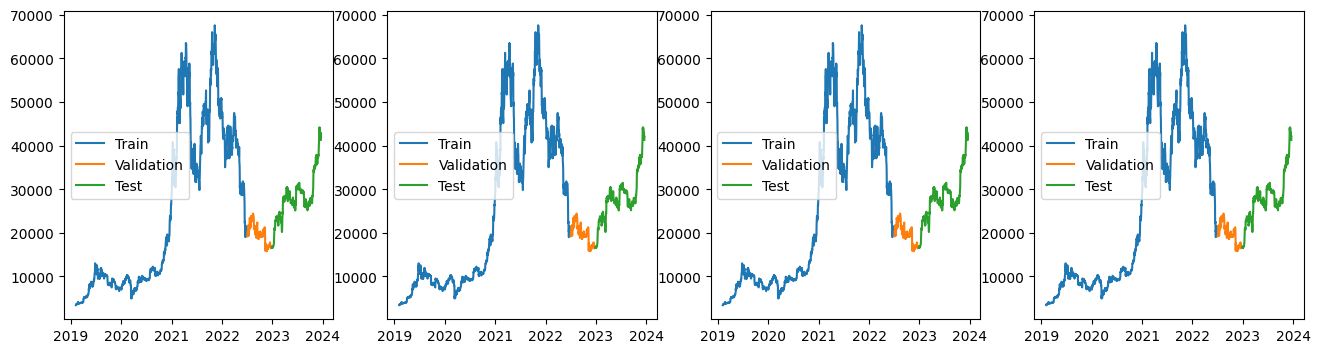

In [74]:
from sklearn.model_selection import train_test_split

train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

df_split_set = {}

fig, axes = plt.subplots(1, len(change_percentages), figsize=(16, 4))
i = 0

for key in df_set.keys():
  dates_df = df_set[key]['dates']
  prices_df = df_set[key]['prices']

  # divide into train, validation and test
  dates_train_val, dates_test = train_test_split(dates_df, test_size=test_percentage, shuffle=False)
  dates_train, dates_val = train_test_split(dates_train_val, test_size=val_percentage/(train_percentage+val_percentage), shuffle=False)

  prices_train_val, prices_test = train_test_split(prices_df, test_size=test_percentage, shuffle=False)
  prices_train, prices_val = train_test_split(prices_train_val, test_size=val_percentage/(train_percentage+val_percentage), shuffle=False)

  df_split_set[key] = {}
  df_split_set[key]['dates'] = {
      'train': dates_train,
      'val': dates_val,
      'test': dates_test
  }
  df_split_set[key]['prices'] = {
      'train': prices_train,
      'val': prices_val,
      'test': prices_test
  }
  ax = axes[i]
  ax.plot(dates_train, prices_train.iloc[:, -2])
  ax.plot(dates_val, prices_val.iloc[:, -2])
  ax.plot(dates_test, prices_test.iloc[:, -2])

  ax.legend(['Train', 'Validation', 'Test'])
  i += 1

In [75]:
for key in df_split_set.keys():
  prices_df = df_split_set[key]['prices']

  prices_train = prices_df['train']
  prices_val = prices_df['val']
  prices_test = prices_df['test']

  scaler = MinMaxScaler()
  # fit scaler on train data
  scaler.fit(prices_train)

  # transform train, validation and test data
  df_split_set[key]['prices']['train'] = scaler.transform(prices_train)
  df_split_set[key]['prices']['val'] = scaler.transform(prices_val)
  df_split_set[key]['prices']['test'] = scaler.transform(prices_test)

In [76]:
for key in df_split_set:
  for split in df_split_set[key]['prices']:
    df_tmp = df_split_set[key]['prices'][split]
    df_split_set[key]['prices'][split] = {
        'X': df_tmp[:,:-1],
        'y': df_tmp[:,-1]
    }

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras import layers, regularizers
from sklearn.utils.class_weight import compute_class_weight

# Suponiendo que y_train es tu conjunto de etiquetas de entrenamiento
# Calcula los pesos de las clases
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
# print(class_weight_dict)

# Modificaciones en la arquitectura del modelo
model = Sequential([
  layers.LSTM(32, input_shape=(10, 1), activation='tanh'),
  layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(.5),
  layers.Dense(1, activation='sigmoid')
  ])

# Ajustes en la tasa de aprendizaje y el decaimiento
lr_schedule = InverseTimeDecay(0.005,
                               decay_steps=5000,
                               decay_rate=0.95,
                               staircase=True)

In [99]:
experiments = list(df_split_set.keys())
len(experiments)

4

In [100]:
experiment_key = experiments[0]
X_train = df_split_set[experiment_key]['prices']['train']['X']
y_train = df_split_set[experiment_key]['prices']['train']['y']
X_val = df_split_set[experiment_key]['prices']['val']['X']
y_val = df_split_set[experiment_key]['prices']['val']['y']

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
#print(class_weight_dict)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)#, class_weight=class_weight_dict)

Epoch 1/30
12/12 [==============================] - 4s 79ms/step - loss: 0.7124 - accuracy: 0.5478 - val_loss: 0.7040 - val_accuracy: 0.8427
Epoch 2/30
12/12 [==============================] - 0s 18ms/step - loss: 0.7047 - accuracy: 0.6236 - val_loss: 0.6934 - val_accuracy: 0.8427
Epoch 3/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6975 - accuracy: 0.6236 - val_loss: 0.6806 - val_accuracy: 0.8427
Epoch 4/30
12/12 [==============================] - 0s 19ms/step - loss: 0.6949 - accuracy: 0.6236 - val_loss: 0.6682 - val_accuracy: 0.8427
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.6919 - accuracy: 0.6236 - val_loss: 0.6565 - val_accuracy: 0.8427
Epoch 6/30
12/12 [==============================] - 0s 13ms/step - loss: 0.6861 - accuracy: 0.6236 - val_loss: 0.6372 - val_accuracy: 0.8427
Epoch 7/30
12/12 [==============================] - 0s 15ms/step - loss: 0.6905 - accuracy: 0.6236 - val_loss: 0.6236 - val_accuracy: 0.8427
Epoch 8/30
12

39/39 [==============================] - 0s 3ms/step
[[675  79]
 [ 78 411]]


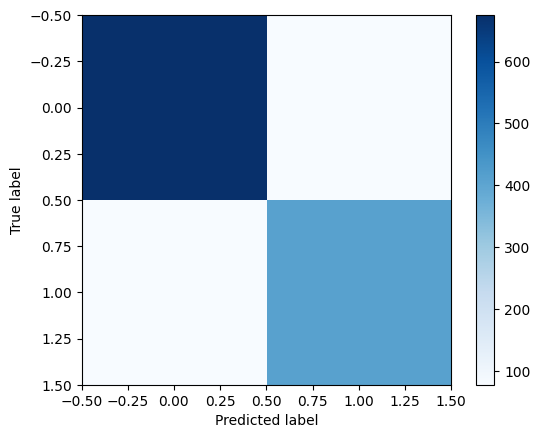

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_train)

# Threshold para convertir la salida del modelo en una predicción binaria
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred_binary)

# Imprimir la matriz de confusión
print(cm)

# Graficar la matriz de confusión
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)

# confusion matrix
import sklearn.metrics as skm

cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

print("Matriz de Confusión:")
print(cm)
print("\nClassification Report:")
print(cr)

39/39 [==============================] - 0s 2ms/step
Matriz de Confusión:
[[675  79]
 [ 78 411]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       754
         1.0       0.84      0.84      0.84       489

    accuracy                           0.87      1243
   macro avg       0.87      0.87      0.87      1243
weighted avg       0.87      0.87      0.87      1243



39/39 [==============================] - 0s 2ms/step


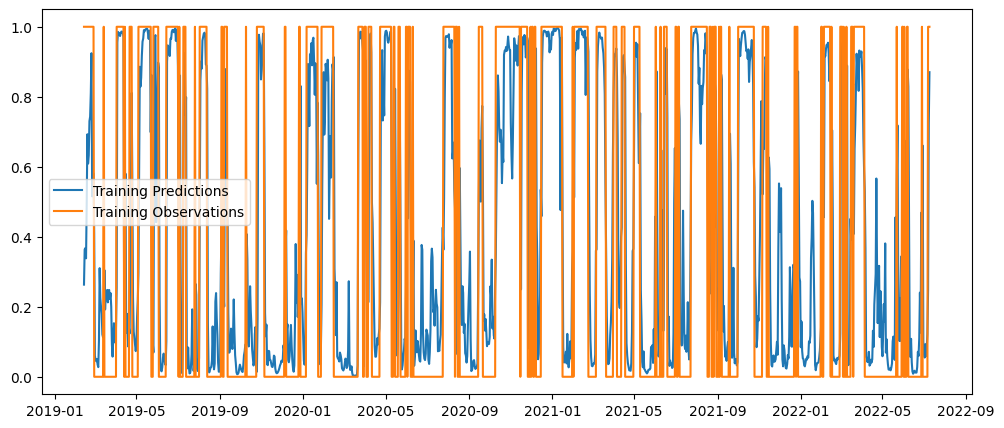

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 [==============================] - 0s 3ms/step


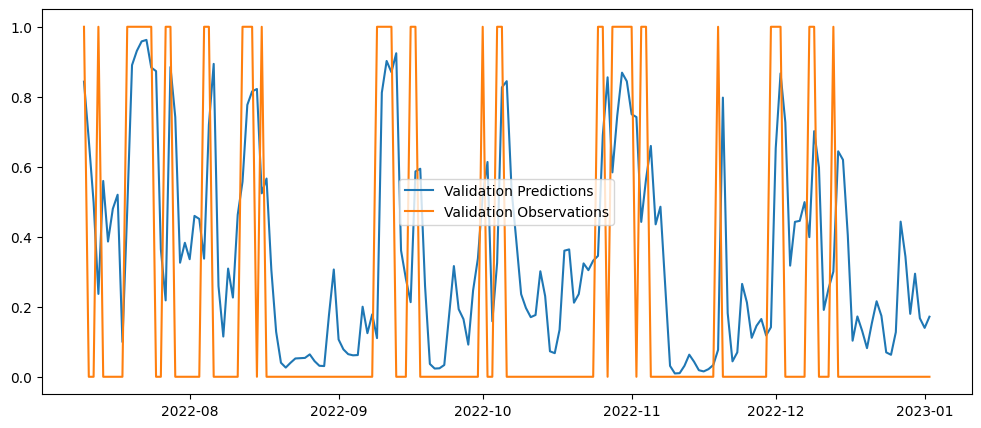

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

12/12 [==============================] - 0s 2ms/step


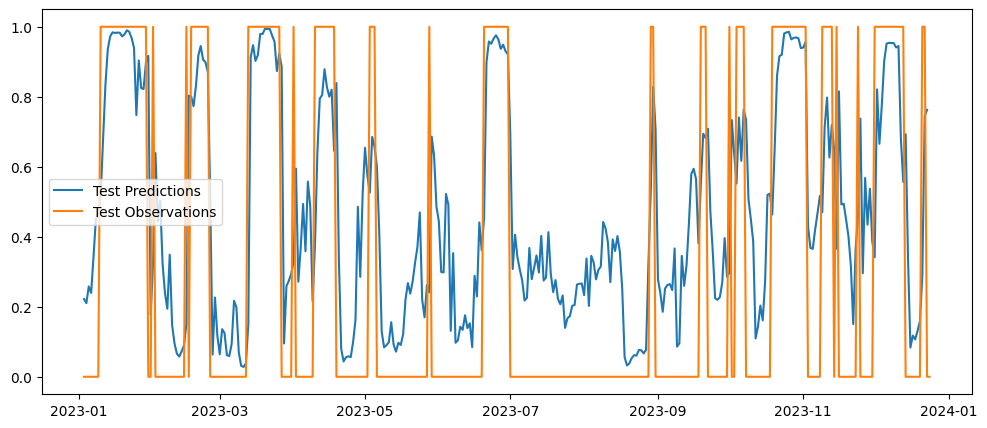

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])